In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b3f38314-d6a0-6e28-24fd-5af8c5906530)


In [1]:
import sys
print( f"Python {sys.version}\n" )

import os
import random
import shutil

import cv2

import numpy as np
print( f"NumPy {np.__version__}\n" )

import pandas as pd
print( f"Pandas {pd.__version__}\n" )

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print( f"Matplotlib {matplotlib.__version__}\n" )
from skimage.transform import resize

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array


# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
# Import WandB


Python 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]

NumPy 1.23.5

Pandas 1.5.3

Matplotlib 3.7.1

TensorFlow 2.14.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):


In [2]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
np.random.seed(1234)
tf.random.set_seed(5678)

In [3]:
# Install WandB
!pip install wandb -qU
# (Optional) Install dotenv to help manage API keys stored in ".env" file
!pip install python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00


In [4]:
import wandb
print(f'WandB {wandb.__version__}')
menu = f"Do you have an environment variable named 'WANDB_API_KEY' stored in .env file?\nYour answer (y/n): "
while True:
  choice = input(menu).lower().strip()

  if choice == 'y':
    # Load 'WANDB_API_KEY' from the ".env" file
    from dotenv import load_dotenv
    load_dotenv()
    WANDB_API_KEY = os.getenv('WANDB_API_KEY')

    # Login with your WandB account
    wandb.login(key=WANDB_API_KEY)
    break

  elif choice == 'n':
    # Login as anonymous (no need for API key)
    wandb.login(anonymous='allow')
    break

  else:
    print('Invalid input. Try again.\n')

WandB 0.15.12
Do you have an environment variable named 'WANDB_API_KEY' stored in .env file?
Your answer (y/n): y


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# **LOAD DATA**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!unzip "/content/drive/MyDrive/data_test/data.zip"

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: data/planes/drone/00000126.jpg  
  inflating: __MACOSX/data/planes/drone/._00000126.jpg  
  inflating: data/planes/drone/00000132.jpg  
  inflating: __MACOSX/data/planes/drone/._00000132.jpg  
  inflating: data/planes/drone/00000318.png  
  inflating: __MACOSX/data/planes/drone/._00000318.png  
  inflating: data/planes/drone/00000683.jpg  
  inflating: __MACOSX/data/planes/drone/._00000683.jpg  
  inflating: data/planes/drone/00000708.jpg  
  inflating: __MACOSX/data/planes/drone/._00000708.jpg  
  inflating: data/planes/drone/00000087.jpeg  
  inflating: __MACOSX/data/planes/drone/._00000087.jpeg  
  inflating: data/planes/drone/00000052.jpg  
  inflating: __MACOSX/data/planes/drone/._00000052.jpg  
  inflating: data/planes/drone/00000046.jpg  
  inflating: __MACOSX/data/planes/drone/._00000046.jpg  
  inflating: data/planes/drone/00000720.jpg  
  inflating: __MACOSX/data/planes/drone/._00000720.jpg  
  inflating: d

In [7]:
import os
import cv2
import numpy as np

# ตั้งค่าพารามิเตอร์
dataset_folder = "/content/data/planes"
img_size = (224, 224)  # ขนาดที่คุณต้องการ resize รูป

x_train = []
y_train = []

# วนลูปตามโฟลเดอร์ย่อยภายในโฟลเดอร์ planes
for class_folder in os.listdir(dataset_folder):
    class_path = os.path.join(dataset_folder, class_folder)

    if os.path.isdir(class_path):
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)

            # อ่านรูปภาพ
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)

            # Check if the image was loaded successfully
            if img is None:
                print(f"Warning: Image not loaded for file: {img_path}")
                continue

            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert จาก BGR เป็น RGB
            img = cv2.resize(img, img_size)

            x_train.append(img)
            y_train.append(class_folder)  # ใช้ชื่อโฟลเดอร์เป็น label



**CONVERT DATA**

In [8]:
x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(3853, 224, 224, 3)
(3853,)


In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(x_train, test_size = 0.2, random_state = 1)
y_train, y_test = train_test_split(y_train, test_size = 0.2, random_state = 1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3082, 224, 224, 3)
(3082,)
(771, 224, 224, 3)
(771,)


In [10]:
unique_labels = np.unique(y_train)
label_to_int = {label: i for i, label in enumerate(unique_labels)}

y_train = np.array([label_to_int[label] for label in y_train])
y_test = np.array([label_to_int[label] for label in y_test])

In [11]:
print( f"x_train: type={type(x_train)} , dtype={x_train.dtype} , shape={x_train.shape} , min={x_train.min(axis=None)} , max={x_train.max(axis=None)}" )
print( f"y_train: type={type(y_train)} , dtype={y_train.dtype} , shape={y_train.shape} , min={min(y_train)} , max={max(y_train)}" )
print( f"x_test: type={type(x_test)} , dtype={x_test.dtype} , shape={x_test.shape} , min={x_test.min(axis=None)} , max={x_test.max(axis=None)}"  )
print( f"y_test: type={type(y_test)} , dtype={y_test.dtype} , shape={y_test.shape} , min={min(y_test)} , max={max(y_test)}" )

x_train: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(3082, 224, 224, 3) , min=0 , max=255
y_train: type=<class 'numpy.ndarray'> , dtype=int64 , shape=(3082,) , min=0 , max=4
x_test: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(771, 224, 224, 3) , min=0 , max=255
y_test: type=<class 'numpy.ndarray'> , dtype=int64 , shape=(771,) , min=0 , max=4


In [12]:
x_train = x_train.astype('uint8')
x_test = x_test.astype('uint8')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [13]:
print( f"x_train: type={type(x_train)} , dtype={x_train.dtype} , shape={x_train.shape} , min={x_train.min(axis=None)} , max={x_train.max(axis=None)}" )
print( f"y_train: type={type(y_train)} , dtype={y_train.dtype} , shape={y_train.shape} , min={min(y_train)} , max={max(y_train)}" )
print( f"x_test: type={type(x_test)} , dtype={x_test.dtype} , shape={x_test.shape} , min={x_test.min(axis=None)} , max={x_test.max(axis=None)}"  )
print( f"y_test: type={type(y_test)} , dtype={y_test.dtype} , shape={y_test.shape} , min={min(y_test)} , max={max(y_test)}" )

x_train: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(3082, 224, 224, 3) , min=0 , max=255
y_train: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(3082,) , min=0.0 , max=4.0
x_test: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(771, 224, 224, 3) , min=0 , max=255
y_test: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(771,) , min=0.0 , max=4.0


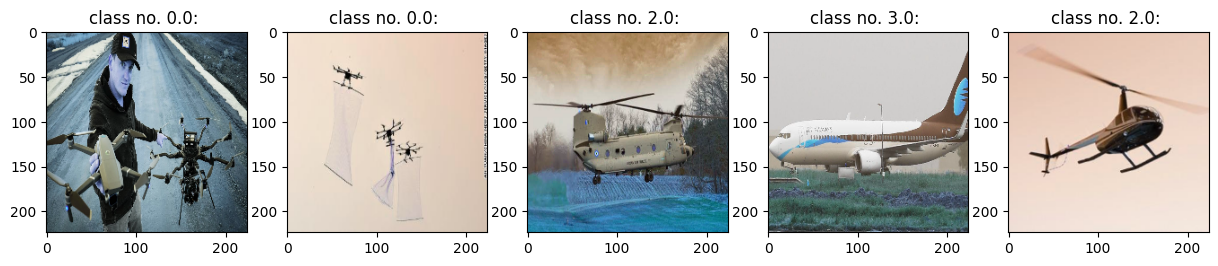

In [14]:
plt.figure(figsize=(15,5))
for i in range(5):
    plt.subplot(150 + 1 + i).set_title( f"class no. {y_train[i]}: " )
    plt.imshow( x_train[i] )
    #plt.axis( "off" )
plt.show()

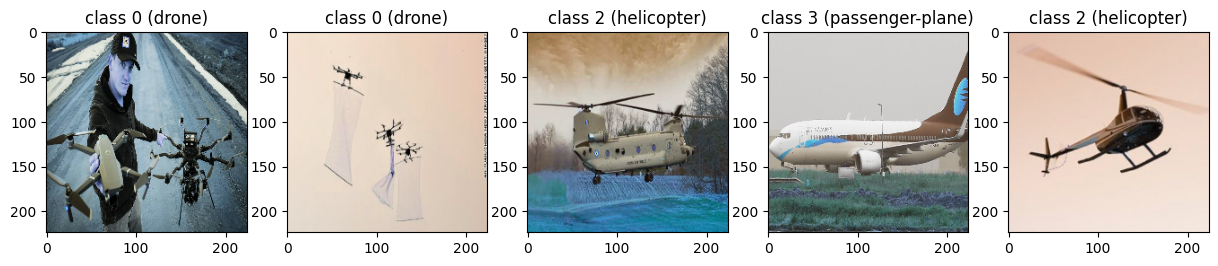

In [15]:
#visualize the first 5 image of x_train
label = ['drone', 'fighter-jet', 'helicopter', 'passenger-plane', 'rocket']

plt.figure(figsize = (15,5))
for i in range(5):
  plt.subplot(150 + 1 + i).set_title(f'class {int(y_train[i])} ({label[int(y_train[i])]})')
  plt.imshow(x_train[i])
plt.show()

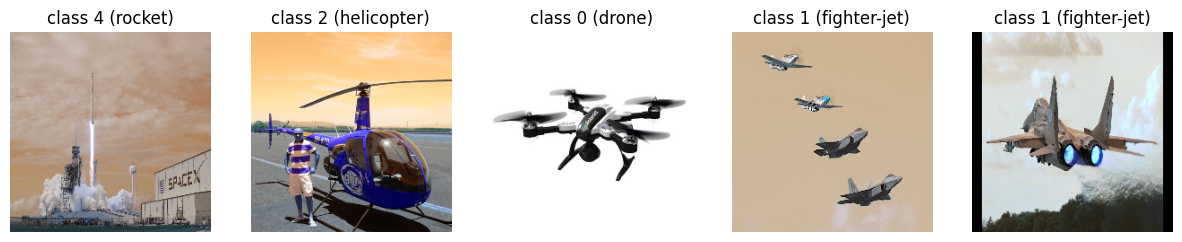

In [16]:
plt.figure(figsize=(15,5))

for i in range(5):
    class_index = int(y_test[i])  # Cast the value to integer
    class_name = label[class_index]
    plt.subplot(150 + 1 + i).set_title(f'class {class_index} ({class_name})')
    plt.imshow(x_test[i])
    plt.axis('off')  # Hide axis for better visualization

plt.show()

**LOAD MODEL**

In [17]:
img_w,img_h = 224, 224
base_model = ResNet101(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
base_model.summary()

171446536/171446536 [==============================] - 1s 0us/step
Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                   

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.879486 to fit



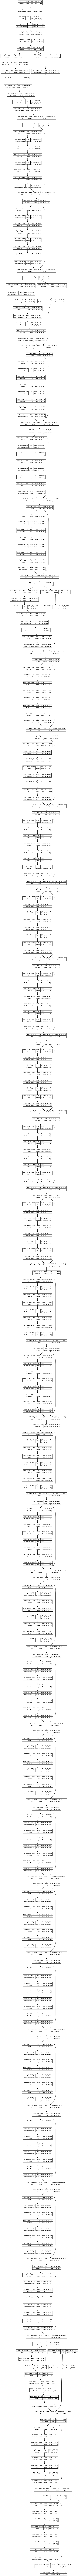

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(base_model, 'ResNet101_Model.png', show_shapes=True,show_layer_names=True)

In [19]:
#Recursively freeze all layers in the model first
base_model.trainable = False

for i, layer in enumerate(base_model.layers):
  print(f'Layer {i}: Name = {layer.name}, Trainable = {layer.trainable}')

Layer 0: Name = input_1, Trainable = False
Layer 1: Name = conv1_pad, Trainable = False
Layer 2: Name = conv1_conv, Trainable = False
Layer 3: Name = conv1_bn, Trainable = False
Layer 4: Name = conv1_relu, Trainable = False
Layer 5: Name = pool1_pad, Trainable = False
Layer 6: Name = pool1_pool, Trainable = False
Layer 7: Name = conv2_block1_1_conv, Trainable = False
Layer 8: Name = conv2_block1_1_bn, Trainable = False
Layer 9: Name = conv2_block1_1_relu, Trainable = False
Layer 10: Name = conv2_block1_2_conv, Trainable = False
Layer 11: Name = conv2_block1_2_bn, Trainable = False
Layer 12: Name = conv2_block1_2_relu, Trainable = False
Layer 13: Name = conv2_block1_0_conv, Trainable = False
Layer 14: Name = conv2_block1_3_conv, Trainable = False
Layer 15: Name = conv2_block1_0_bn, Trainable = False
Layer 16: Name = conv2_block1_3_bn, Trainable = False
Layer 17: Name = conv2_block1_add, Trainable = False
Layer 18: Name = conv2_block1_out, Trainable = False
Layer 19: Name = conv2_block2_

**PRE PROCESSING DATA**

In [20]:
#Pre-processing
x_train_resnet101 =  tf.keras.applications.resnet.preprocess_input (x_train)
x_test_resnet101 = tf.keras.applications.resnet.preprocess_input (x_test)

print(x_train_resnet101.shape)
print(x_test_resnet101.shape)

(3082, 224, 224, 3)
(771, 224, 224, 3)


**DATA AUGMENT**

In [21]:
batch_size = 32




train_datagen = ImageDataGenerator(
   #rescale=1. / 255,
        #featurewise_center=True,
        samplewise_center=True,
        #featurewise_std_normalization=True,
        samplewise_std_normalization=True,
        #zca_whitening=False,
        rotation_range=0,
        width_shift_range=5.0,
        height_shift_range=5.0,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.3)
train_datagen.fit(x_train_resnet101)

test_datagen = ImageDataGenerator(
     #rescale=1. / 255,
        # featurewise_center=True,
        samplewise_center=True,
        # featurewise_std_normalization=True,
        samplewise_std_normalization=True)
test_datagen.fit(x_test_resnet101)


===== Train batch no. 1/1 =====


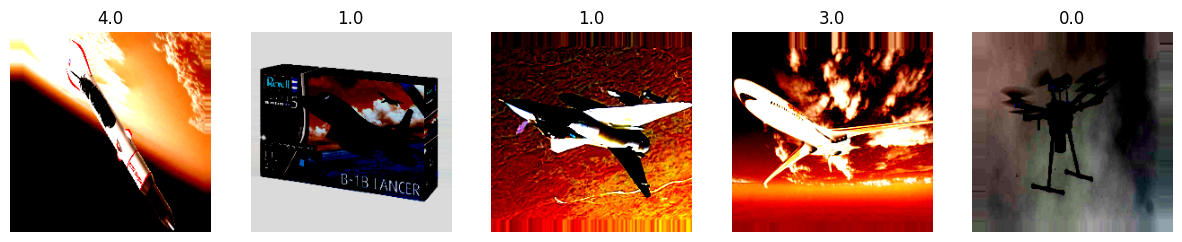

In [22]:
n_show = 1    # show 'n_show' batches of generated data (1 batch includes 5 images)

for b, (x_batch, y_batch) in enumerate( train_datagen.flow( x_train, y_train, batch_size=5, subset='training' ) ):
  print( f"===== Train batch no. {b+1}/{n_show} =====" )
  plt.figure(figsize=(15,5))
  for i in range(5):
      plt.subplot(150 + 1 + i).set_title( y_batch[i] )
      plt.imshow( x_batch[i])
      plt.axis( "off" )        # remove all tick marks
  plt.show()

  if b+1 >= n_show:
    break


===== Train batch no. 1/1 =====


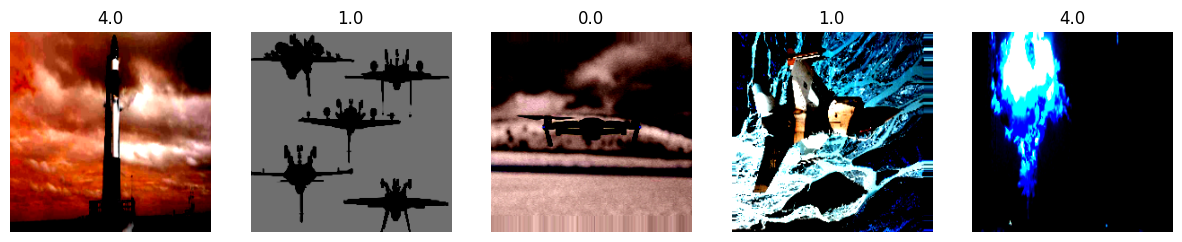

In [23]:
n_show = 1    # show 'n_show' batches of generated data (1 batch includes 5 images)

for b, (x_batch, y_batch) in enumerate( train_datagen.flow( x_train, y_train, batch_size=5, subset='validation' ) ):
  print( f"===== Train batch no. {b+1}/{n_show} =====" )
  plt.figure(figsize=(15,5))
  for i in range(5):
      plt.subplot(150 + 1 + i).set_title( y_batch[i] )
      plt.imshow( x_batch[i])
      plt.axis( "off" )        # remove all tick marks
  plt.show()

  if b+1 >= n_show:
    break

In [24]:
x = base_model.output

#Add our custom layer(s) to the end of the existing model
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(64, activation = 'relu')(x)

x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(5, activation = 'softmax')(x)

#construct the main model
model = tf.keras.models.Model(inputs = base_model.inputs, outputs = new_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

**TRAIN & EVALUATE**

In [25]:
from tensorflow.keras.optimizers import Adam
from traitlets import validate

optimizer = Adam(learning_rate=0.001)

model.compile( loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["acc"] )

In [26]:
print(y_train.shape)
print(y_train.dtype)


(3082,)
float32


In [27]:
num_classes = len(np.unique(y_train))
print(num_classes)


5


In [28]:
y_train[0:10]

array([0., 0., 2., 3., 2., 0., 3., 1., 0., 3.], dtype=float32)

In [29]:
from wandb.keras import WandbCallback
wandb.init(project='Nick_RestNet_No_Fine_tuning', entity='deep-a')

wandb: Currently logged in as: sanpetch-t (deep-a). Use `wandb login --relogin` to force relogin


In [30]:
history = model.fit(train_datagen.flow(x_train_resnet101 ,y_train,batch_size=32,subset='training'),epochs = 20, verbose = 2,
                    validation_data=train_datagen.flow(x_train_resnet101 ,y_train,batch_size=32,subset='validation'),
                    callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231101_155117-tiiaano3/files/model-best)... Done. 4.0s


68/68 - 125s - loss: 2.4435 - acc: 0.3526 - val_loss: 1.2164 - val_acc: 0.4848 - 125s/epoch - 2s/step
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231101_155117-tiiaano3/files/model-best)... Done. 15.4s


68/68 - 122s - loss: 1.2491 - acc: 0.4926 - val_loss: 1.0783 - val_acc: 0.5552 - 122s/epoch - 2s/step
Epoch 3/20
68/68 - 48s - loss: 1.1096 - acc: 0.5278 - val_loss: 1.1118 - val_acc: 0.5303 - 48s/epoch - 701ms/step
Epoch 4/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231101_155117-tiiaano3/files/model-best)... Done. 24.2s


68/68 - 145s - loss: 1.0181 - acc: 0.5774 - val_loss: 0.9799 - val_acc: 0.6266 - 145s/epoch - 2s/step
Epoch 5/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231101_155117-tiiaano3/files/model-best)... Done. 22.6s


68/68 - 168s - loss: 0.9338 - acc: 0.6270 - val_loss: 0.9367 - val_acc: 0.6504 - 168s/epoch - 2s/step
Epoch 6/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231101_155117-tiiaano3/files/model-best)... Done. 28.7s


68/68 - 149s - loss: 0.9220 - acc: 0.6386 - val_loss: 0.9137 - val_acc: 0.6613 - 149s/epoch - 2s/step
Epoch 7/20
68/68 - 49s - loss: 0.8799 - acc: 0.6474 - val_loss: 0.9805 - val_acc: 0.6374 - 49s/epoch - 726ms/step
Epoch 8/20
68/68 - 46s - loss: 0.8202 - acc: 0.6816 - val_loss: 1.0031 - val_acc: 0.6764 - 46s/epoch - 683ms/step
Epoch 9/20
68/68 - 46s - loss: 0.8331 - acc: 0.6946 - val_loss: 0.9573 - val_acc: 0.6688 - 46s/epoch - 680ms/step
Epoch 10/20
68/68 - 46s - loss: 0.7995 - acc: 0.6951 - val_loss: 1.0496 - val_acc: 0.6310 - 46s/epoch - 682ms/step
Epoch 11/20
68/68 - 46s - loss: 0.7567 - acc: 0.7048 - val_loss: 1.0236 - val_acc: 0.6515 - 46s/epoch - 683ms/step
Epoch 12/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231101_155117-tiiaano3/files/model-best)... Done. 8.8s


68/68 - 110s - loss: 0.7551 - acc: 0.7257 - val_loss: 0.8899 - val_acc: 0.6840 - 110s/epoch - 2s/step
Epoch 13/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231101_155117-tiiaano3/files/model-best)... Done. 9.4s


68/68 - 107s - loss: 0.6796 - acc: 0.7442 - val_loss: 0.8613 - val_acc: 0.6894 - 107s/epoch - 2s/step
Epoch 14/20
68/68 - 46s - loss: 0.6099 - acc: 0.7790 - val_loss: 0.9291 - val_acc: 0.7100 - 46s/epoch - 679ms/step
Epoch 15/20
68/68 - 46s - loss: 0.6478 - acc: 0.7804 - val_loss: 0.8796 - val_acc: 0.6981 - 46s/epoch - 674ms/step
Epoch 16/20
68/68 - 46s - loss: 0.6299 - acc: 0.7697 - val_loss: 1.0773 - val_acc: 0.6461 - 46s/epoch - 678ms/step
Epoch 17/20
68/68 - 47s - loss: 0.6103 - acc: 0.7938 - val_loss: 0.9755 - val_acc: 0.6981 - 47s/epoch - 684ms/step
Epoch 18/20
68/68 - 46s - loss: 0.5685 - acc: 0.8049 - val_loss: 1.0216 - val_acc: 0.6872 - 46s/epoch - 677ms/step
Epoch 19/20
68/68 - 46s - loss: 0.5982 - acc: 0.7919 - val_loss: 0.8757 - val_acc: 0.7240 - 46s/epoch - 672ms/step
Epoch 20/20
68/68 - 46s - loss: 0.5030 - acc: 0.8369 - val_loss: 1.0775 - val_acc: 0.6645 - 46s/epoch - 677ms/step


In [31]:
wandb.finish()

In [32]:
results = model.evaluate(test_datagen.flow(x_test_resnet101, y_test, batch_size = 128))
print(f'{model.metrics_names}: {results}')

7/7 [==============================] - 9s 711ms/step - loss: 0.9353 - acc: 0.7237
['loss', 'acc']: [0.9353165626525879, 0.7237353920936584]


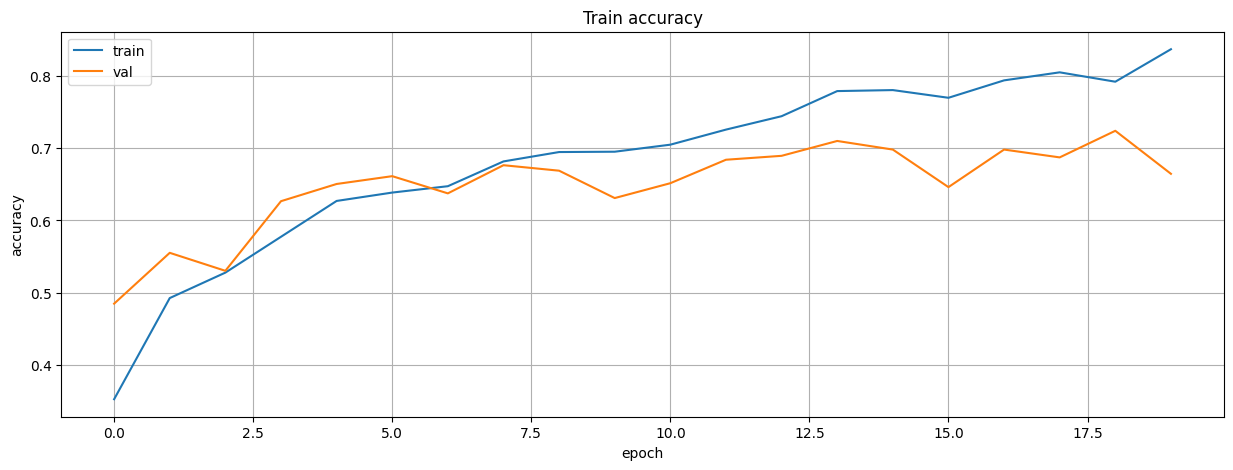

In [33]:
#Summarize history of accuracy
plt.figure(figsize = (15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.grid()
plt.show()

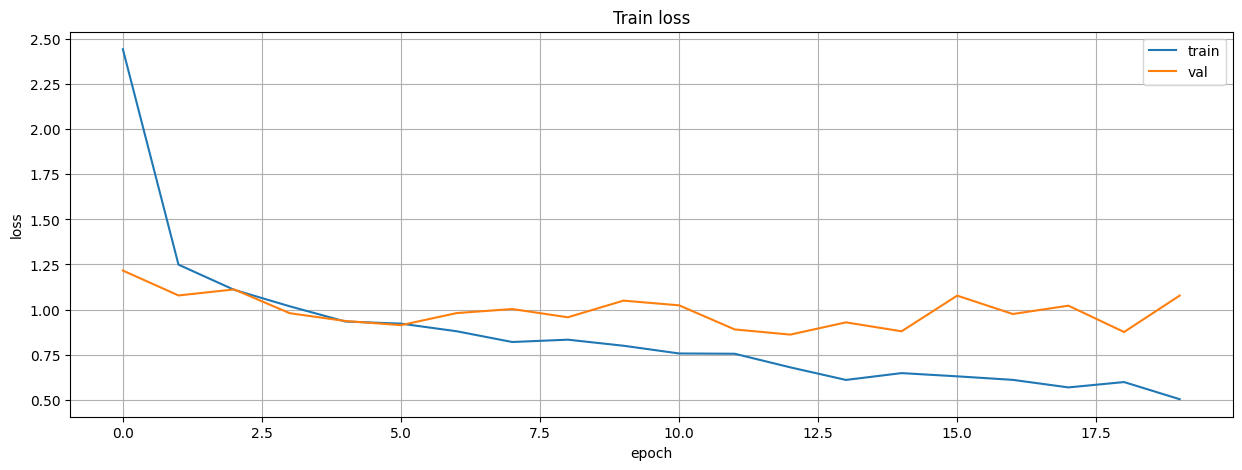

In [34]:
#Summarize history for loss
plt.figure(figsize = (15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper right')
plt.grid()
plt.show()

In [35]:
plt.rcParams["axes.linewidth"] = 5

def color_frame( ax, y_true, y_pred ):
  color = 'green' if (y_true == y_pred) else 'red'
  ax.spines['bottom'].set_color(color)
  ax.spines['top'].set_color(color)
  ax.spines['right'].set_color(color)
  ax.spines['left'].set_color(color)

samples.shape=(10, 224, 224, 3)
1/1 [==============================] - 3s 3s/step


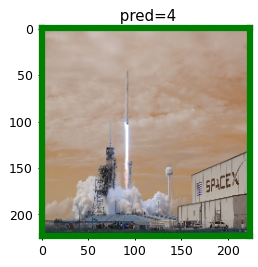

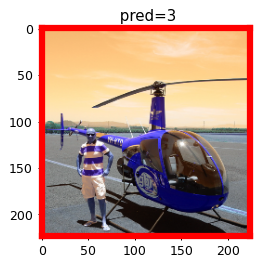

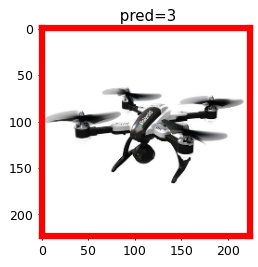

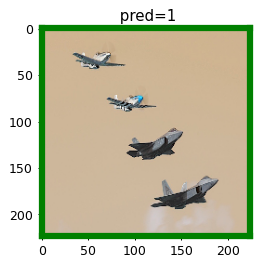

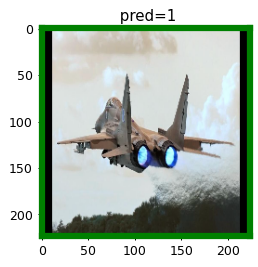

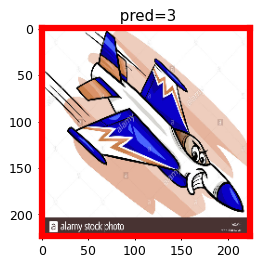

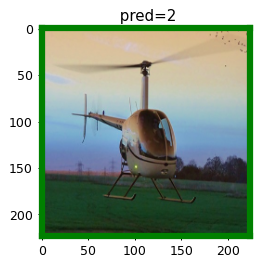

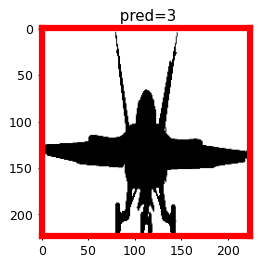

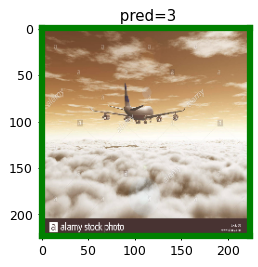

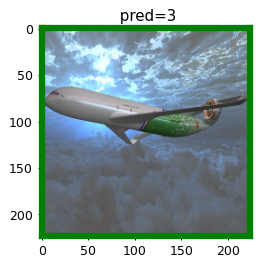

In [36]:
# Test using the model on many images


# Get a batch of samples
n = 10
samples = x_test[:n]
print(f'{samples.shape=}')

# Predict a batch of samples
y_pred = model.predict(samples)

# Interpret the results
for i in range(n):
  plt.figure(figsize=(3,3), dpi=90)
  ax = plt.gca()
  plt.imshow( x_test[i] )
  plt.title(f" pred={np.argmax(y_pred[i])}")
  color_frame(ax, y_test[i], np.argmax(y_pred[i]))
  plt.show()

**GRAD-CAM**

In [37]:
import keras

img_size = (224, 224)
preprocess_input = keras.applications.vgg16.preprocess_input
last_conv_layer_name = "conv5_block3_out"

1/1 [==============================] - 4s 4s/step
Predicted: passenger-plane | Actual: rocket 


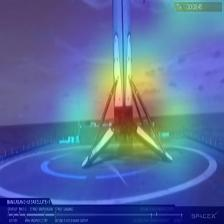

1/1 [==============================] - 0s 35ms/step
Predicted: passenger-plane | Actual: drone 


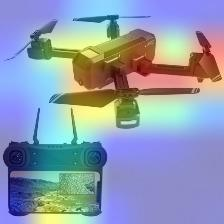

1/1 [==============================] - 0s 29ms/step
Predicted: passenger-plane | Actual: helicopter 


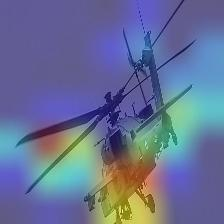

1/1 [==============================] - 0s 30ms/step
Predicted: passenger-plane | Actual: fighter-jet 


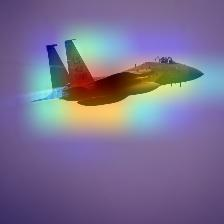

1/1 [==============================] - 0s 29ms/step
Predicted: passenger-plane | Actual: passenger-plane 


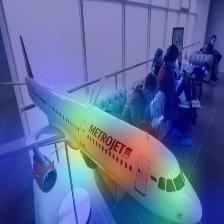

In [38]:
from IPython.display import Image, display
import matplotlib.cm as cmp


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
          last_conv_layer_output, preds = grad_model(img_array)
          if pred_index is None:
              pred_index = tf.argmax(preds[0])
          class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.8):
      img = img_path

      # Rescale heatmap to a range 0-255
      heatmap = np.uint8(255 * heatmap)

      # Use jet colormap to colorize heatmap
      jet = plt.get_cmap("jet")

      # Use RGB values of the colormap
      jet_colors = jet(np.arange(256))[:, :3]
      jet_heatmap = jet_colors[heatmap]

      # Create an image with RGB colorized heatmap
      jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
      jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
      jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

      # Superimpose the heatmap on original image
      superimposed_img = jet_heatmap * alpha + img
      superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

      # Save the superimposed image
      superimposed_img.save(cam_path)

      # Display Grad CAM
      display(Image(cam_path))

for i in range(5):
  c= np.random.randint(0,180)
  img_path = x_test[c]
  img_array = preprocess_input(img_path)
  model.layers[-1].activation = None
  preds = model.predict(img_array.reshape(-1,224,224,3))
  print(f"Predicted: {label[int(np.argmax(preds))]} | Actual: {label[int(y_test[c])]} ")
  heatmap = make_gradcam_heatmap(img_array.reshape(1,224,224,3), model, last_conv_layer_name)
  save_and_display_gradcam(img_path, heatmap)